In [52]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO

## Monthly Environment Simulation

In [53]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
}

In [54]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
    }
    env = greenCrabMonthEnv(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [29]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


2025-02-27 01:26:04,309	INFO worker.py:1841 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.6388
Function value obtained: 18.5372
Current minimum: 18.5372
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3098
Function value obtained: 21.0641
Current minimum: 18.5372
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3245
Function value obtained: 41.2899
Current minimum: 18.5372
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3263
Function value obtained: 47.5398
Current minimum: 18.5372
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3218
Function value obtained: 10.3612
Current minimum: 10.3612
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Ev

[0.0, 271.2268262115927, 0.0]

In [30]:
# with nonNormalized env
evaluateConstAct(
    [0.0, 271.2268262115927, 0.0]
)

0.834776533159004

In [31]:
import ray
ray.shutdown()

In [55]:
env = greenCrabMonthEnv(config)
agent = multiConstAction(env=env, action=np.array([0.0, 271.2268262115927, 0.0]))
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,0.0,0.0,271.226826,0.0,0.000000,0
1,1,0.0,0.0,271.226826,0.0,-0.007294,0
2,2,0.0,0.0,271.226826,0.0,-0.014588,0
3,3,0.0,0.0,271.226826,0.0,-0.021882,0
4,4,0.0,0.0,271.226826,0.0,-0.029176,0


<Axes: xlabel='t'>

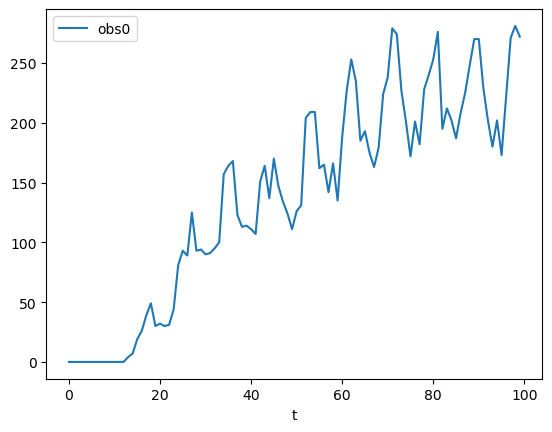

In [56]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

In [57]:
def environment_simulation(env, agent, reps=10, obs_names = None, acts_names = None):
    num_obs = np.prod(env.observation_space.shape)
    num_acts = np.prod(env.action_space.shape)
    obs_names = obs_names or [f'obs{i}' for i in range(num_obs)]
    acts_names = acts_names or [f'act{i}' for i in range(num_acts)]
    #
    data = {
        't': [],
        **{obsn: [] for obsn in obs_names},
        **{actn: [] for actn in acts_names},
        'rew': [],
        'rep': [],
        'crab_pop':[]
    }
    env = env
    agent = agent
    for rep in range(reps): # try score as average of 100 replicates, still a noisy measure
        episode_reward = 0.0
        observation, _ = env.reset()
        for t in range(env.Tmax):
            action, _ = agent.predict(observation, deterministic=True)
            #
            data['rew'].append(episode_reward)
            data['rep'].append(rep)
            data['t'].append(t)
            data['crab_pop'].append(env.state)
            for idx, obs_name in enumerate(obs_names):
                data[obs_name].append(observation[idx])
            for idx, act_name in enumerate(acts_names):
                data[act_name].append(action[idx])
            #
            observation, reward, terminated, done, info = env.step(action)
            episode_reward += reward
            #
            if terminated or done:
                break
    return data

In [61]:
agent = multiConstAction(env=env, action=np.array([0.0, 100, 0.0]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep,crab_pop
0,0,0.0,0.0,100.0,0.0,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,317.0,0.0,100.0,0.0,-0.267667,0,"[4.489725770711212, 103.28666950892793, 780.59..."
2,2,301.0,0.0,100.0,0.0,-0.535333,0,"[0.4568268606684955, 15.128402394995996, 177.7..."
3,3,314.0,0.0,100.0,0.0,-0.803000,0,"[0.010803518294331937, 1.930427323701139, 35.0..."
4,4,307.0,0.0,100.0,0.0,-1.070666,0,"[0.0007242877363217973, 0.15073345658635734, 5..."


In [62]:
crab_pop_df = pd.DataFrame(constantDataDF[constantDataDF['rep']==0]['crab_pop'].tolist(), columns=[f'crab_pop_{i}' for i in range(len(constantDataDF['crab_pop'][0]))])
crab_pop_df['t'] = constantDataDF['t']
crab_pop_df.head()

,crab_pop_0,crab_pop_1,crab_pop_2,crab_pop_3,crab_pop_4,crab_pop_5,crab_pop_6,crab_pop_7,crab_pop_8,crab_pop_9,...,crab_pop_12,crab_pop_13,crab_pop_14,crab_pop_15,crab_pop_16,crab_pop_17,crab_pop_18,crab_pop_19,crab_pop_20,t
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,4.489726,103.286670,780.597680,2195.741855,2145.869276,839.695482,163.709820,143.758693,399.339560,754.234041,...,690.163806,715.881692,823.219362,883.524103,918.324075,969.997004,968.384602,814.106203,459.614618,1
2,0.456827,15.128402,177.783028,896.839093,2002.481940,1915.187758,843.470147,230.842427,237.807703,519.146460,...,764.396659,705.975414,777.030409,861.391188,905.428330,953.948377,949.539981,799.584151,449.027097,2
3,0.010804,1.930427,35.040624,267.843740,1014.999420,1879.195469,1698.295133,789.091290,289.079126,343.814608,...,811.563261,731.231361,749.198597,830.665280,893.634545,931.677785,930.624429,782.894448,436.122501,3
4,0.000724,0.150733,5.565857,67.559665,381.792195,1127.406176,1769.701045,1475.460469,694.157614,341.865704,...,806.804722,775.655502,751.990874,802.696669,879.916687,922.646105,909.724952,765.978927,428.347396,4


In [63]:
def plot_selected_sizes(expanded_df:pd.DataFrame, selected_sizes):
    plt.figure(figsize=(12, 8))
    time = expanded_df['t']  # Time column

    # If no sizes selected, show a placeholder message
    if not selected_sizes:
        plt.text(0.5, 0.5, 'No sizes selected', fontsize=20, ha='center', va='center')
        plt.axis('off')
        plt.show()
        return

    # Plot each selected size
    for col in selected_sizes:
        plt.plot(time, expanded_df[col], label=col)

    # Customize the plot
    plt.title("Green Crab Population Change Over Time", fontsize=16)
    plt.xlabel("Time (t)", fontsize=14)
    plt.ylabel("Population", fontsize=14)
    plt.legend(title="Crab Sizes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Create a multi-select widget for crab size columns
crab_pop_columns = [col for col in crab_pop_df.columns if col.startswith('crab_pop_')]
size_selector = widgets.SelectMultiple(
    options=crab_pop_columns,
    value=[crab_pop_columns[0]],  # Default selection
    description='Sizes',
    disabled=False
)
# Create an interactive plot
interact(lambda selected_sizes: plot_selected_sizes(crab_pop_df, selected_sizes), selected_sizes=size_selector);

interactive(children=(SelectMultiple(description='Sizes', index=(0,), options=('crab_pop_0', 'crab_pop_1', 'cr…

### normalized environment

In [11]:
config

{'w_mort_scale': 600, 'growth_k': 0.7}

In [12]:
env = greenCrabMonthEnvNormalized(config)
agent = multiConstAction(env=env, action=np.array([-0.22713126, -0.21056502, -0.16036674]))

In [13]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized(config)
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [14]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [49]:
normalized_action([0.0, 271.2268262115927, 0.0], max_action)

array([-1.        , -0.81918212, -1.        ])

In [15]:
evaluateConstAct([-1.        , -0.71918212, -1.        ])

2025-03-07 04:48:01,524	INFO worker.py:1841 -- Started a local Ray instance.


1.2186302433423017

In [16]:
import ray
ray.shutdown()

In [17]:
agent = multiConstAction(env=env, action=np.array([-1.        , -0.71918212, -1.        ]))

In [18]:
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.719182,-1.0,0.000000,0
1,1,-1.0,-1.0,-0.719182,-1.0,-0.011294,0
2,2,-1.0,-1.0,-0.719182,-1.0,-0.022588,0
3,3,-1.0,-1.0,-0.719182,-1.0,-0.033882,0
4,4,-1.0,-1.0,-0.719182,-1.0,-0.045176,0


<Axes: xlabel='t'>

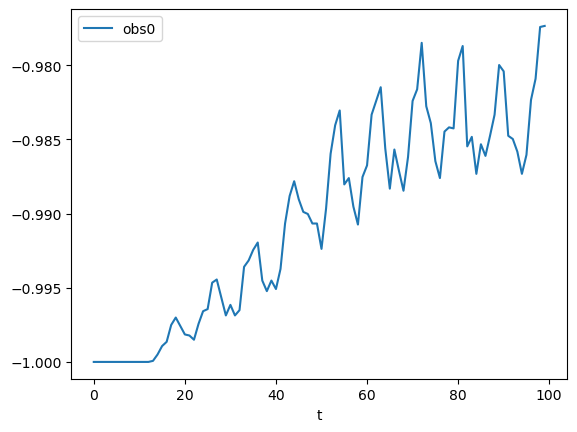

In [19]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [20]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [21]:
evalEnv = greenCrabMonthEnvNormalized(config)

In [65]:
td3Agent = TD3.load("TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load("PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load("TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm", device="cpu")

In [66]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-03-07 17:40:54,267	INFO worker.py:1841 -- Started a local Ray instance.


In [67]:
import ray
ray.shutdown()

In [68]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -1.4214530849319627
TQC mean rew = -1.5587972035784439
TD3 mean rew = -1.6425018083975818
RecurrentPPO mean rew = -1.911110811251176



### RecurrentPPO plot

In [69]:
reppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
reppoDataDF = pd.DataFrame(reppoData)
reppoDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.000000,-1.0,-0.728118,-1.0,0.000000,0
1,1,-0.992350,-1.0,-0.727866,-1.0,-0.011289,0
2,2,-0.989858,-1.0,-0.727782,-1.0,-0.022660,0
3,3,-0.987216,-1.0,-0.727693,-1.0,-0.034114,0
4,4,-0.987734,-1.0,-0.727710,-1.0,-0.045653,0


<Axes: xlabel='t'>

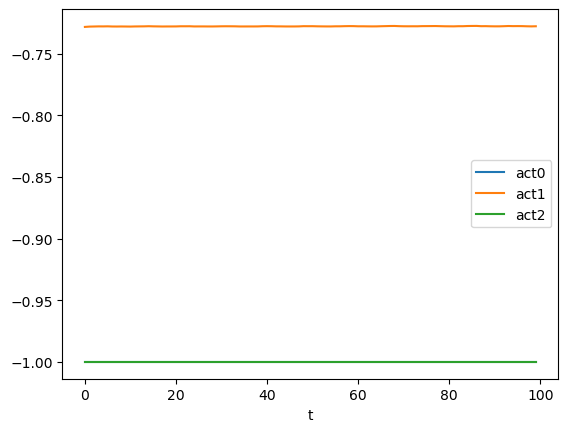

In [70]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

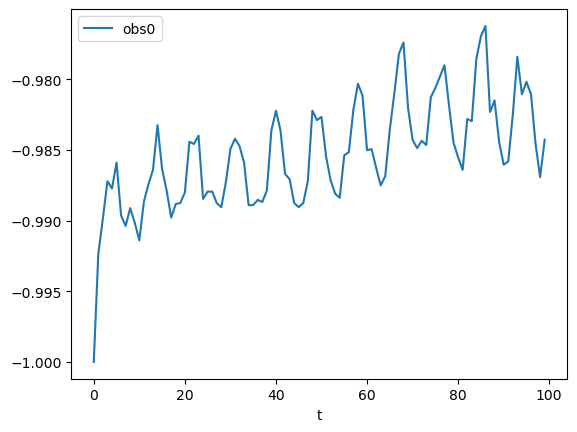

In [71]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['obs0'])